# Analyse of oscilloscope and camera data

In [228]:
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
import matplotlib.dates as mdates
import datetime

%pylab inline --no-import-all

#directory = '/storage/experiments/2021/0726_bourka_zabori' 
#directory = '/storage/experiments/2021/0807_bourka_sobeslav' 
directory = '/storage/experiments/2021/0725_bourka_ratmirov'

#filename = '1627370541.5541592'
#filename = '1628432100.1519039'
filename = '1627300500.3458862'

filename2 = 'RigolDS6'

antenna_file = directory + '/slavia/csv/' + filename2 + '.csv'
video_file = directory + '/video/' + filename + '.mp4.csv'
wfm_file = directory + '/slavia/' + filename + '.wfm'


Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_table(antenna_file, sep=',', header=0)
print(df.columns)
df.shape[0]*8e-9
#df.shape[0]*1e-6

Index(['CH1(V)', 'CH2(V)', 't0 = -0.5s', ' tInc = 8e-09s', 'Unnamed: 4'], dtype='object')


0.40140800000000004

In [3]:
df['time']=df.index*8e-9 # fillin of correct sample time

#df['time']=df.index*4e-9 # fillin of correct sample time
#df['time']=df.index*19.93e-09 # fillin of correct sample time
#df['time']=df.index*1e-06 # fillin of correct sample time


In [4]:
df.set_index('time', inplace=True)
df.drop(df.columns[2:5], inplace=True, axis=1)
#df.drop(df.columns[2], inplace=True, axis=1)
#df.drop(df.columns[2], inplace=True, axis=1)

In [5]:
df.index = pd.to_datetime(df.index, unit='s')

In [6]:
y = pd.read_csv(video_file)
y['time'] = (y.index)*(1/1610)

In [364]:
xx = df.resample('1us', closed='left').mean()

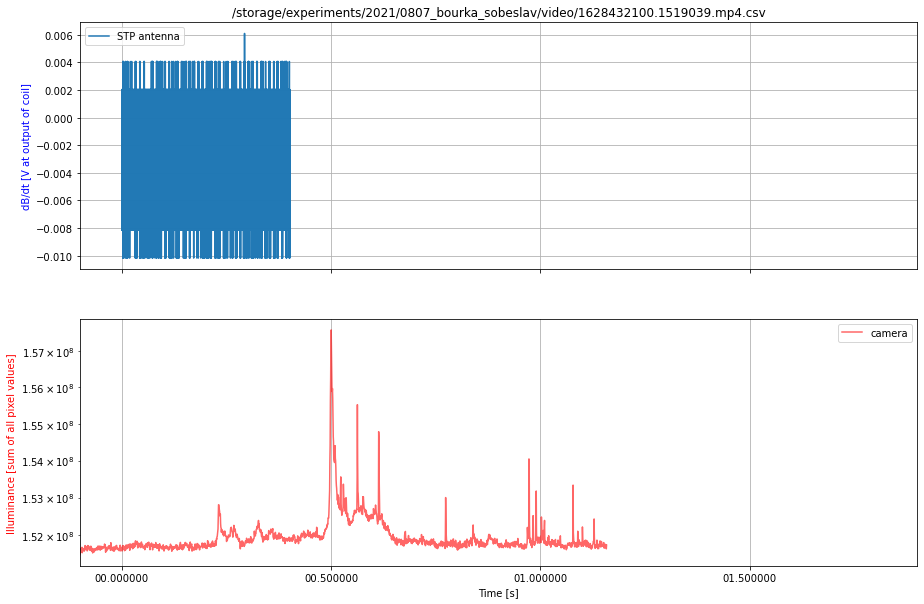

In [12]:
fig, (ax1,  ax2) = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)

ax1.plot(xx['CH2(V)'], label='STP antenna', alpha=0.99)
#plt.xlabel('Time [s]')
ax1.set_ylabel('dB/dt [V at output of coil]', c='b')
ax1.grid()
ax1.legend(loc = "upper left")
ax1. set_title(video_file)

#ax1.set_xlim(pd.to_datetime(0, unit='s'),pd.to_datetime(0.8, unit='s'))
ax1.set_xlim(pd.to_datetime(-0.1, unit='s'),pd.to_datetime(1.9, unit='s'))

#y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.380, unit='s')
#y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.350, unit='s')
#y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.670, unit='s')
#y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.635, unit='s')
y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.740, unit='s')

ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
ax2.set_yscale('log')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Illuminance [sum of all pixel values]', c='r')
ax2.grid()
ax2.legend(loc = "upper right")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%S.%f'))
#plt.ylim(90,10e2)

In [11]:
xx = df.sort_index()
#df.shape[0]*19.93e-09
#plt.plot(df['CH2(V)'])

# wfm file

In [229]:
dt = np.dtype([('a', 'u1')])
bytes_read = np.fromfile(wfm_file, dtype=dt)

In [230]:
offset = 0x10
SetupSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C
LAdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x1c
CHdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x30
MemDepth = int.from_bytes(bytes_read[offset:offset+4], "big")
print(CHdataSize, MemDepth)
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x39
#ch1 = list(bytes_read[offset:offset+CHdataSize:2])
#ch2 = bytes_read[offset+1:offset+CHdataSize:2]
df = pd.DataFrame(bytes_read[offset+1:offset+CHdataSize:2])
df['time']=pd.to_datetime(df.index*4e-9, unit='s', origin='unix') # fillin of correct sample time
df.set_index('time', inplace=True)

500000032 125000000


In [238]:
xx = df.resample('10us', closed='left').mean()

In [231]:
y = pd.read_csv(video_file)
y['time'] = (y.index)*(1/1610)

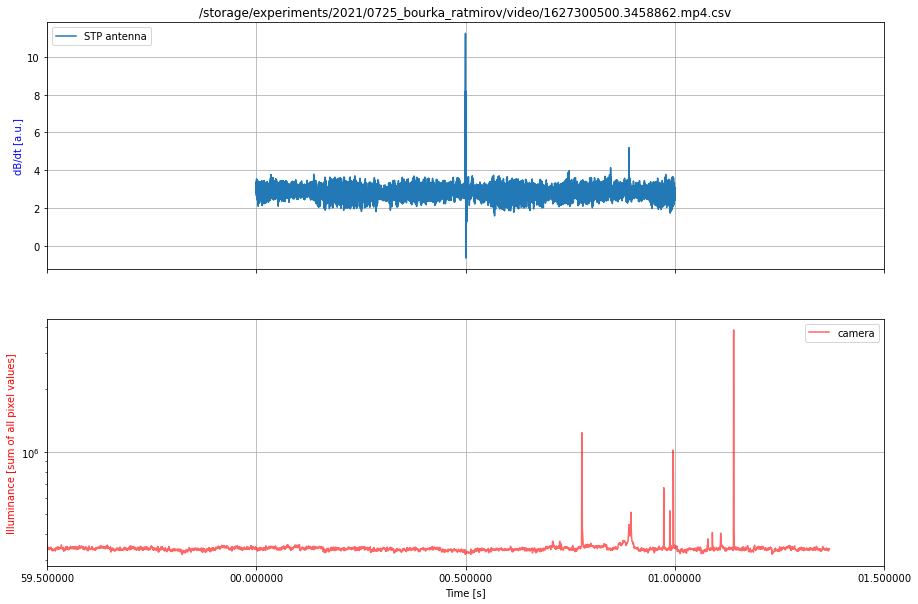

In [239]:
fig, (ax1,  ax2) = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)

ax1.plot(xx-128, label='STP antenna', alpha=0.99)
#plt.xlabel('Time [s]')
ax1.set_ylabel('dB/dt [a.u.]', c='b')
ax1.grid()
ax1.legend(loc = "upper left")
ax1. set_title(video_file)

#ax1.set_xlim(pd.to_datetime(0, unit='s'),pd.to_datetime(0.8, unit='s'))
ax1.set_xlim(pd.to_datetime(-0.5, unit='s'),pd.to_datetime(1.5, unit='s'))

y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.630, unit='s')

ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
ax2.set_yscale('log')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Illuminance [sum of all pixel values]', c='r')
ax2.grid()
ax2.legend(loc = "upper right")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%S.%f'))
#plt.ylim(90,10e2)

## Save to HDF

In [31]:
# skip if not needed

cols_to_keep = ['CH1(V)', 'CH2(V)']
df.index = pd.to_datetime(df.index, unit='s')
df.loc[:, cols_to_keep].to_hdf(file+'.hdf','df', mode='w')

In [53]:
df.index = pd.to_datetime(df.index, unit='s')
df.loc[:, 'CH2(V)'].to_hdf(file+'.hdf','df', mode='w')

In [32]:
#df.loc[:] #
df.loc[:, 'CH2(V)']

## Read data

In [366]:
# Read oscilloscope data
df=pd.read_hdf(file+'.hdf')
plt.figure(figsize=(15,5))
plt.plot(df['CH2(V)'])
#plt.plot(df)

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

NameError: name 'file' is not defined

In [ ]:
# Display oscilloscope data
#df.index = pd.to_datetime(df.index, unit='s')

plt.figure(figsize=(15,5))
plt.plot(df['CH2(V)'])
#plt.plot(df)

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()


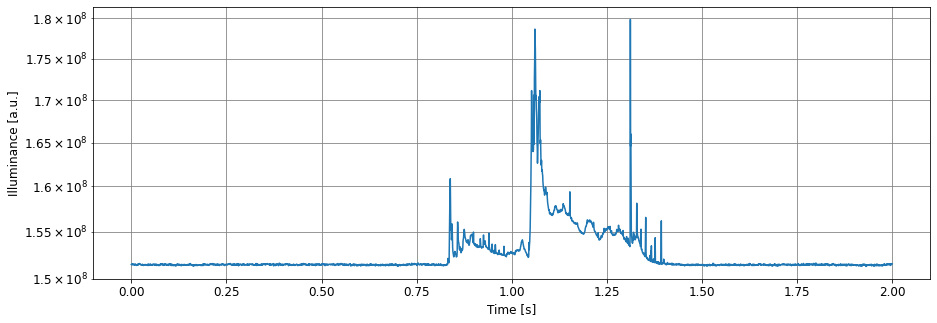

In [217]:
# Read illuminance data

y = pd.read_csv(video_file)

plt.figure(figsize=(15,5))
plt.rc('font', size=12)    

#y['time'] = (y.index - 1613)*(1/1610)
y['time'] = (y.index)*(1/1610)

plt.plot(y['time'], y['0'])
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
#plt.xticks(np.arange(0, 4000, 100))


## Resample oscilloscope data

In [218]:
def custom_resampler(arraylike):
    return np.log(np.mean(arraylike))

#xx = df.resample('1us', closed='left').mean()
#xx = df.resample('1us', closed='left').apply(custom_resampler)
xx = df.resample('1us', closed='left').mean()


# Plot antenna and camera data together

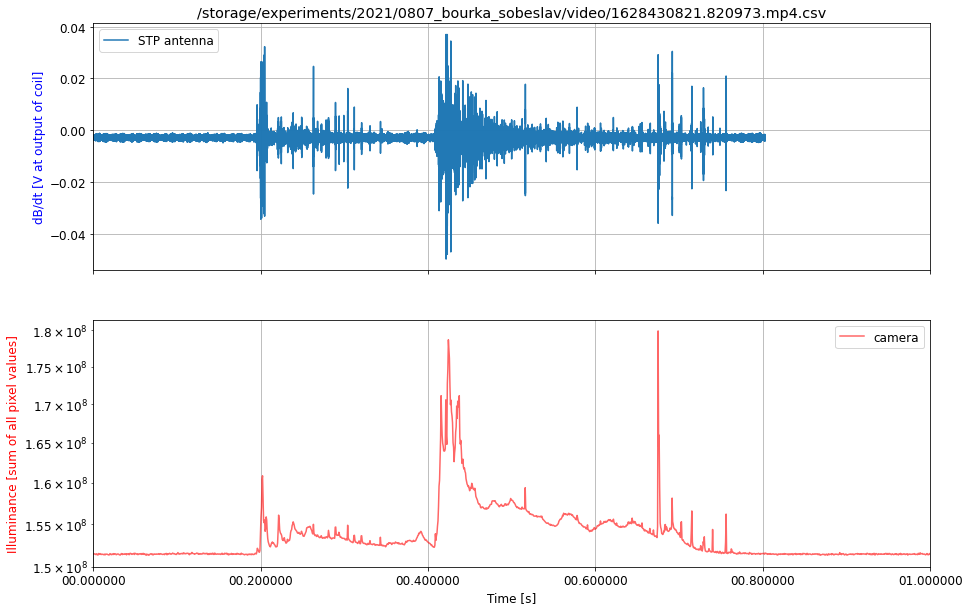

In [225]:
fig, (ax1,  ax2) = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)

ax1.plot(xx['CH2(V)'], label='STP antenna', alpha=0.99)
#plt.xlabel('Time [s]')
ax1.set_ylabel('dB/dt [V at output of coil]', c='b')
ax1.grid()
ax1.legend(loc = "upper left")
ax1. set_title(video_file)

#ax1.set_xlim(pd.to_datetime(0, unit='s'),pd.to_datetime(0.8, unit='s'))
ax1.set_xlim(pd.to_datetime(-0., unit='s'),pd.to_datetime(1., unit='s'))

#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')
#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.665, unit='s')
#y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.380, unit='s')
#y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.350, unit='s')
#y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.670, unit='s')
y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.635, unit='s')

ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
ax2.set_yscale('log')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Illuminance [sum of all pixel values]', c='r')
ax2.grid()
ax2.legend(loc = "upper right")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%S.%f'))
#plt.ylim(90,10e2)

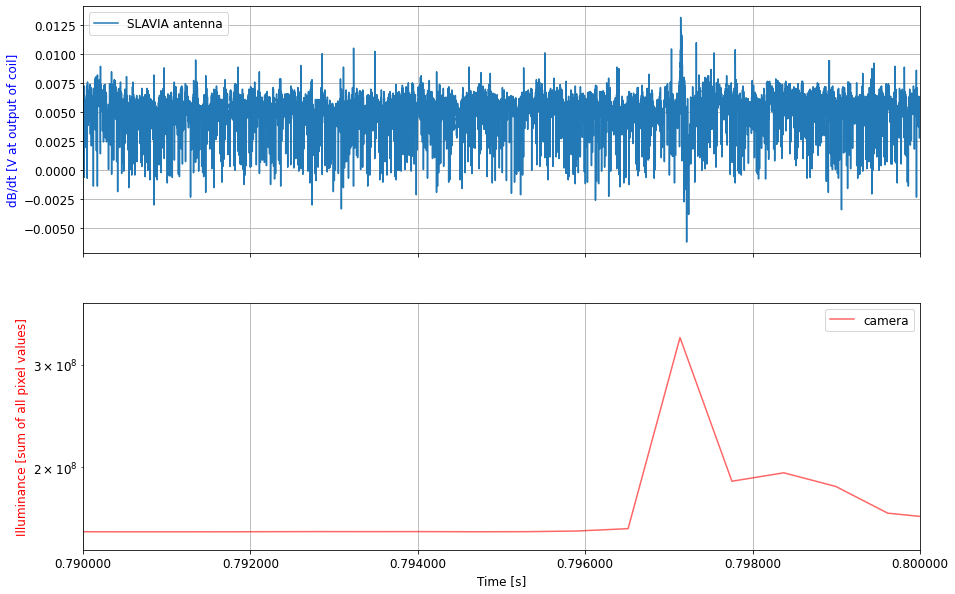

In [182]:
fig, (ax1,  ax2) = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)

#FROM_TIME = 0.406
#TO_TIME = 0.408
#FROM_TIME = 0.2
#TO_TIME = 0.6
#xx = df.loc[pd.to_datetime(FROM_TIME, unit='s'):pd.to_datetime(TO_TIME, unit='s')]
#xx = df.loc[pd.to_datetime(FROM_TIME, unit='s'):pd.to_datetime(TO_TIME, unit='s')]

ax1.plot(xx['CH1(V)'], label='SLAVIA antenna', alpha=0.99)
#plt.xlabel('Time [s]')
ax1.set_ylabel('dB/dt [V at output of coil]', c='b')
ax1.grid()
ax1.legend(loc = "upper left")

ax1.set_xlim(pd.to_datetime(0.79, unit='s'),pd.to_datetime(0.8, unit='s'))

#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')
#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.615, unit='s')
y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.349, unit='s')

ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
ax2.set_yscale('log')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Illuminance [sum of all pixel values]', c='r')
ax2.grid()
ax2.legend(loc = "upper right")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('0.%f'))
#plt.ylim(90,10e2)
#plt.xlim(pd.to_datetime(FROM_TIME, unit='s'),pd.to_datetime(TO_TIME, unit='s'))

In [367]:
xx = df[0.4:0.5]
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.plot(xx['CH1(V)'], label='CH1')
plt.plot(xx['CH2(V)'], label='CH2')
#plt.ylim(-0.1,0)
plt.legend()
plt.grid()

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [0.4] of type float

In [45]:

#df.loc['00:00:00.100':'00:00:00.200']
FROM_TIME = 0.4
TO_TIME = 0.5
#df.between_time(pd.to_datetime(FROM_TIME, format='%S.%f', errors='ignore'),pd.to_datetime(TO_TIME, format='%S.%f', errors='ignore'))

pd.to_datetime(FROM_TIME, format='%S.%f', errors='ignore')
df.loc[pd.to_datetime(FROM_TIME, unit='s'):pd.to_datetime(TO_TIME, unit='s')]

,CH1(V),CH2(V)
time,,
1970-01-01 00:00:00.400000000,0.000000,0.000000
1970-01-01 00:00:00.400000008,0.014711,0.000000
1970-01-01 00:00:00.400000016,0.022067,0.000000
1970-01-01 00:00:00.400000024,-0.044134,0.000000
1970-01-01 00:00:00.400000032,0.022067,0.000841
...,...,...
1970-01-01 00:00:00.499999968,0.080912,0.021015
1970-01-01 00:00:00.499999976,-0.150791,0.030262
1970-01-01 00:00:00.499999984,-0.139758,0.044552


# Light curve with antenna

In [3]:
#f = "/storage/experiments/2021/0807_bourka_sobeslav" + "/video/1628431195.5110645.mp4.csv"
#df=pd.read_hdf(file+'/slavia/hdf/RigolDS0.csv.hdf')
#f = "/storage/experiments/2021/0725_bourka_ratmirov" + "/video/1627302288.9546976.mp4.csv"
#df=pd.read_hdf(file+'/slavia/hdf/RigolDS1.csv.hdf')
f = "/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713811.182914.mp4.csv"
df=pd.read_hdf(file+'.hdf')
#f = "/storage/experiments/2021/0725_bourka_ratmirov" + "/video/1627302184.9854863.mp4.csv"
#df=pd.read_hdf(file+'/slavia/hdf/RigolDS2.csv.hdf')
df['CH2(V)']

time
0.000000e+00   -0.001681
8.000000e-09   -0.001681
1.600000e-08   -0.001681
2.400000e-08   -0.000841
3.200000e-08   -0.000841
                  ...   
8.028160e-01   -0.000841
8.028160e-01   -0.000841
8.028160e-01   -0.001681
8.028160e-01   -0.001681
8.028160e-01   -0.001681
Name: CH2(V), Length: 100352000, dtype: float64

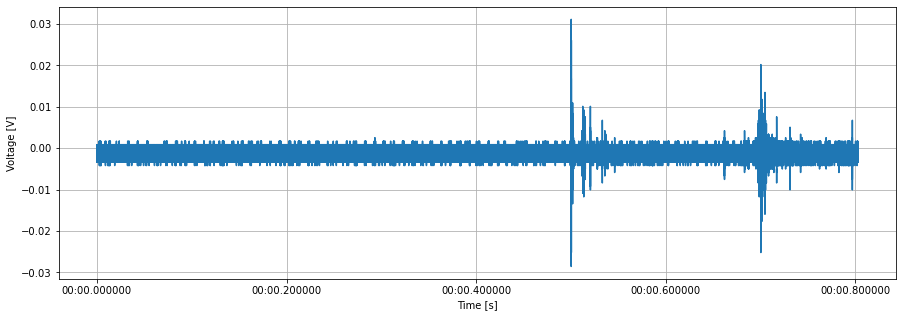

In [368]:
plt.figure(figsize=(15,5))
plt.plot(df['CH2(V)'])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

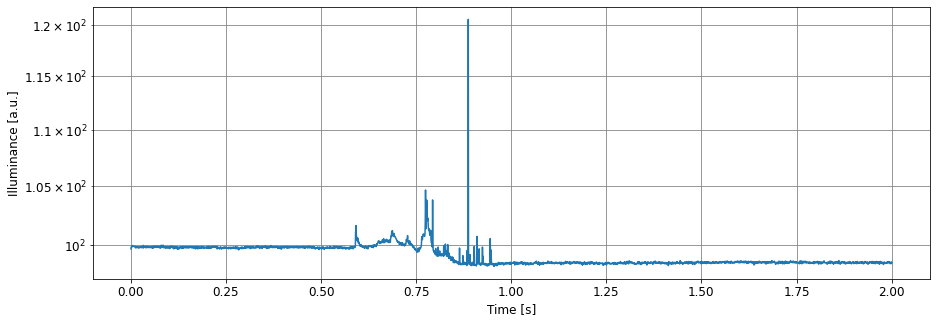

In [89]:
y = pd.read_csv(f)

plt.figure(figsize=(15,5))
plt.rc('font', size=12)    

#y['time'] = (y.index - 1613)*(1/1610)
y['time'] = (y.index)*(1/1610)

plt.plot(y['time'], y['0'])
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
#plt.xticks(np.arange(0, 4000, 100))


In [ ]:
df.index = pd.to_datetime(df.index, unit='s')

In [74]:
xx = df.resample('1us', closed='left').mean()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(xx['CH2(V)'], label='antenna', alpha=0.99)
#plt.plot(df['CH1(V)'], label='antenna')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.xlim(pd.to_datetime(0, unit='s'),pd.to_datetime(0.8, unit='s'))

plt.twinx()

#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')
y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.615, unit='s')

plt.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")
#plt.ylim(90,10e2)

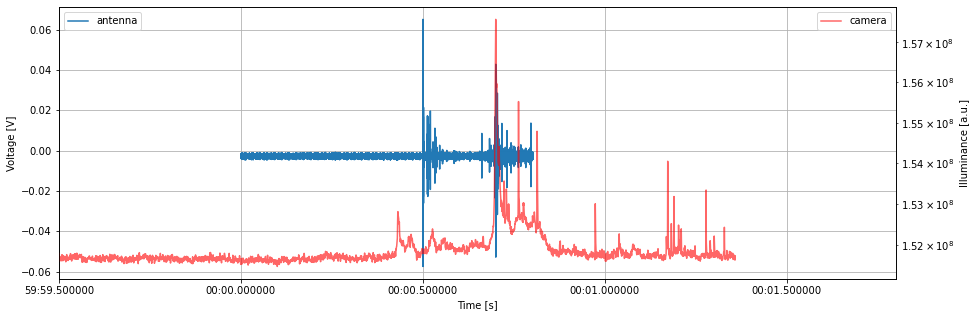

In [356]:
plt.figure(figsize=(15,5))
plt.plot(xx['CH2(V)'], label='antenna', alpha=0.99)
#plt.plot(df['CH1(V)'], label='antenna')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.xlim(pd.to_datetime(-0.5, unit='s'),pd.to_datetime(1.8, unit='s'))

plt.twinx()

#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')
#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.060, unit='s')
y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.640, unit='s')

plt.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")
#plt.ylim(90,10e2)

Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is n

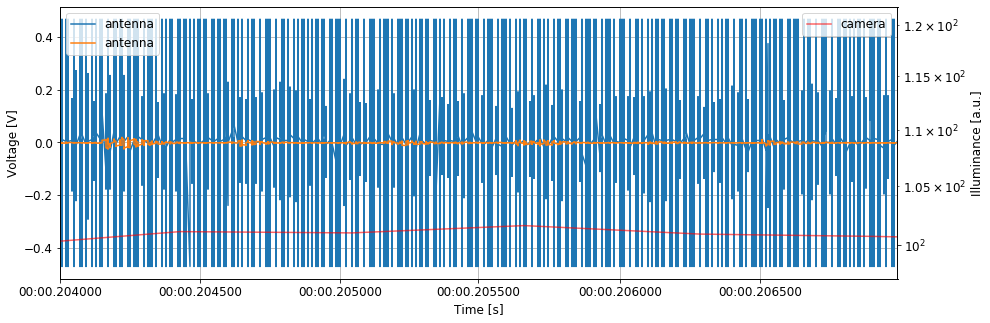

In [101]:
plt.figure(figsize=(15,5))
plt.plot(df['CH1(V)'], label='antenna')
plt.plot(xx['CH2(V)'], label='antenna', alpha=0.99)
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.xlim(pd.to_datetime(0.204, unit='s'),pd.to_datetime(0.207, unit='s'))

plt.twinx()

#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')
y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.615, unit='s')

plt.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")
#plt.ylim(90,10e2)

In [36]:
plt.figure(figsize=(15,5))
#df.index = pd.to_datetime(df.index, unit='s')
plt.plot(df['CH2(V)'], label='antenna')

#plt.plot(df['CH2(V)'].resample('1ms').mean(), label='antenna filt.')
#plt.plot(df['CH1(V)'], label='antenna')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.twinx()

y['time'] = (y.index - 1613)*(1/1612.38)+0.194

plt.plot(y['time'], y['0'], c='red', alpha=0.5, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")


KeyError: 'CH2(V)'

<Figure size 1080x360 with 0 Axes>

In [104]:
df = df.loc[-0.15:0,'CH2(V)'].copy()

In [18]:
df=df.reset_index()

In [141]:
first = df['CH2(V)'].idxmin()
second = df.loc[first+10:,'CH2(V)'].idxmin()
second = df.loc[first+10:first+6000,'CH2(V)'].idxmin()
period = second - first

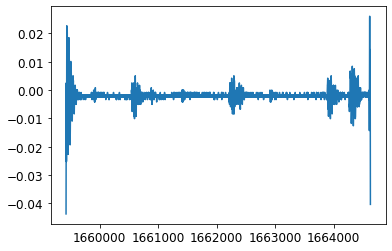

In [142]:
plt.plot(df.loc[first:second,'CH2(V)'])

In [147]:
xx = df['CH2(V)'].to_numpy()
periods = round(len(xx)/period)-1
xx = xx[:period*periods]
periodic = xx.reshape(periods, period)
avg_signal = periodic.mean(axis=0)

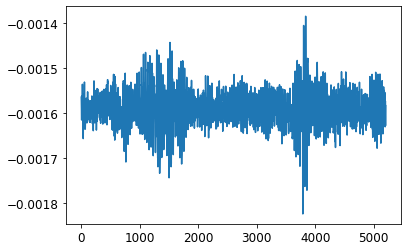

In [148]:
plt.plot(avg_signal)

In [10]:
df.index = pd.to_datetime(df.index, unit='s')

In [12]:
xx = df.resample('1us', closed='left').mean()

MemoryError: Unable to allocate 730. TiB for an array with shape (100351999000002,) and data type int64

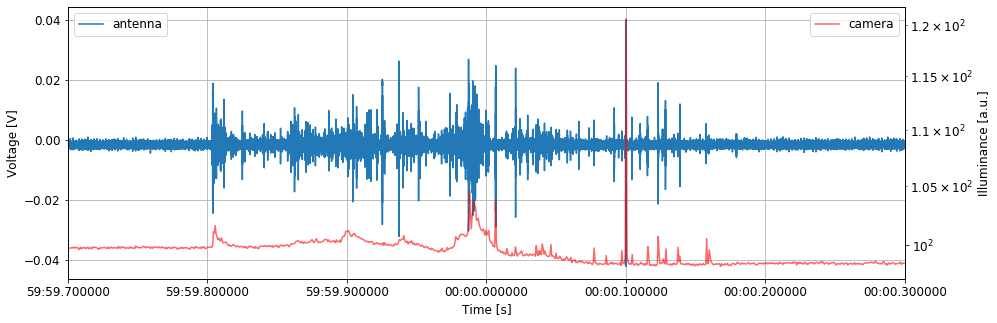

In [69]:
plt.figure(figsize=(15,5))
plt.plot(xx['CH2(V)'], label='antenna', alpha=0.99)
#plt.plot(df['CH1(V)'], label='antenna')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.xlim(pd.to_datetime(-0.3, unit='s'),pd.to_datetime(0.3, unit='s'))

plt.twinx()

y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')

plt.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")
#plt.ylim(90,10e2)

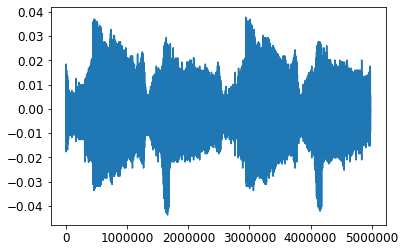

In [97]:
df.loc[:2*period,'CH2(V)'].plot()

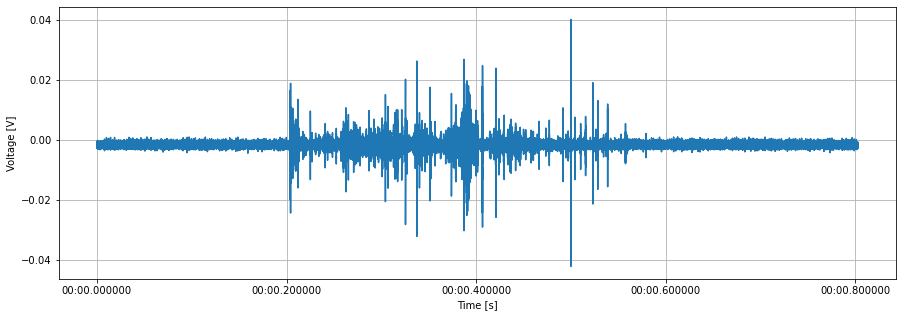

In [7]:
plt.figure(figsize=(15,5))
plt.plot(xx['CH2(V)'])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

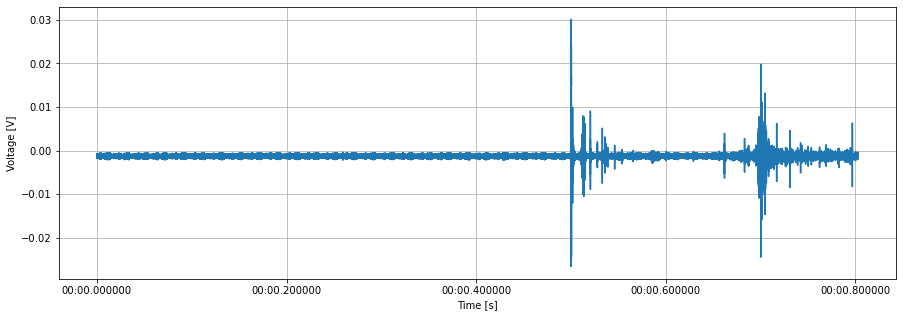

In [379]:
plt.figure(figsize=(15,5))
plt.plot(xx['CH2(V)'].loc[pd.to_datetime('1970-01-01 0:0:0.'):pd.to_datetime('1970-01-01 0:0:1.502')])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

In [13]:
xx

,CH1(V),CH2(V)
time,,
1970-01-01 00:00:00.000000,0.004708,-0.001056
1970-01-01 00:00:00.000001,0.004708,-0.000908
1970-01-01 00:00:00.000002,0.003884,-0.000854
1970-01-01 00:00:00.000003,0.004943,-0.001036
1970-01-01 00:00:00.000004,0.004090,-0.000968
...,...,...
1970-01-01 00:00:00.802811,0.006414,-0.001506
1970-01-01 00:00:00.802812,0.006061,-0.001769
1970-01-01 00:00:00.802813,0.006561,-0.002031


In [7]:
df.reset_index(inplace=True)

Text(0, 0.5, 'Voltage [V]')

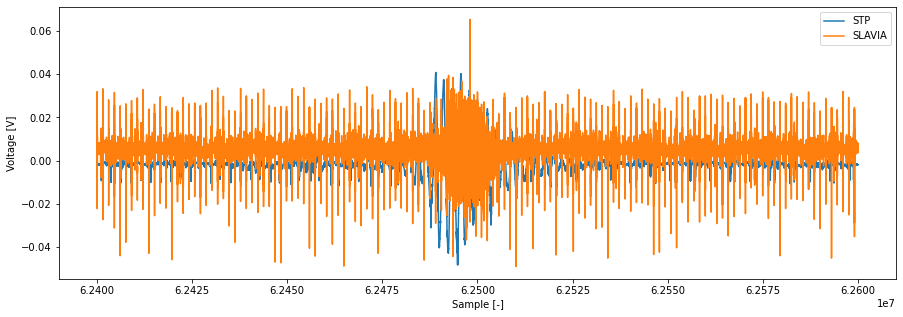

In [8]:
plt.figure(figsize=(15,5))

# CG returnstroke
f = 0.624e8
t = 0.626e8
# initiation
#f = 0.21e8
#t = 0.212e8
plt.plot(df['CH2(V)'].loc[f:t].rolling(20).mean(), label="STP")
plt.plot(df['CH1(V)'].loc[f:t].rolling(20).mean(), label="SLAVIA")
plt.legend()
plt.xlabel('Sample [-]')
plt.ylabel('Voltage [V]')



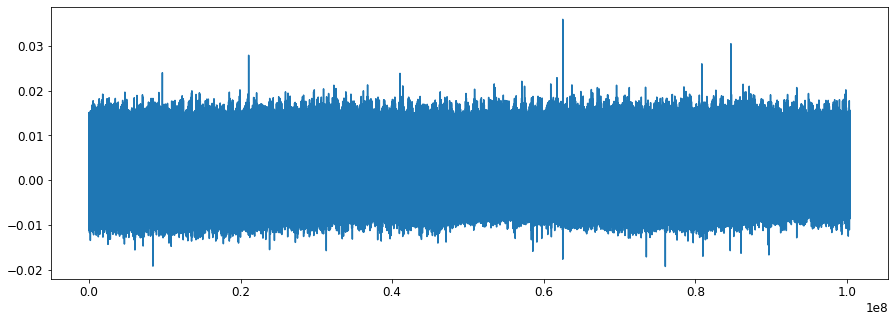

In [10]:
plt.figure(figsize=(15,5))
#df.reset_index(inplace=True)
plt.plot(df['CH1(V)'].rolling(50).mean())

In [3]:
from numpy import array
a = array(df['CH1(V)'],'float32')
output_file = open('file1.f32', 'wb')
a.tofile(output_file)
output_file.close()

## Save Luminosity to file

In [84]:
y = y.rename({'0': 'luminosity'}, axis = 1)
y.set_index('time', inplace=True)
cols_to_keep = ['luminosity']
y.loc[:, cols_to_keep].to_hdf('luminosity.hdf','df', mode='w')


,Unnamed: 0,luminosity
time,,
1969-12-31 23:59:59.614615476,0,99.706557
1969-12-31 23:59:59.615235677,1,99.852945
1969-12-31 23:59:59.615855878,2,99.842566
1969-12-31 23:59:59.616476079,3,99.865827
1969-12-31 23:59:59.617096281,4,99.951296
...,...,...
1970-01-01 00:00:01.609802714,3217,98.479353
1970-01-01 00:00:01.610422915,3218,98.544715
1970-01-01 00:00:01.611043116,3219,98.631330


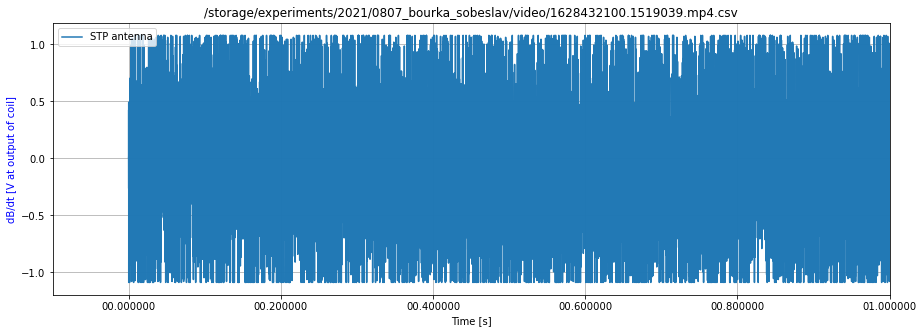

In [42]:
xx = df
fig, (ax1) = plt.subplots(figsize=(15, 5), nrows=1, sharex=True)

ax1.plot(xx['CH1(V)'], label='STP antenna', alpha=0.99)
ax1.set_ylabel('dB/dt [V at output of coil]', c='b')
ax1.grid()
ax1.legend(loc = "upper left")
ax1. set_title(video_file)

ax1.set_xlim(pd.to_datetime(-0.1, unit='s'),pd.to_datetime(1., unit='s'))

ax1.set_xlabel('Time [s]')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%S.%f'))


In [3]:
z=pd.read_hdf('luminosity.hdf')
z

,luminosity
time,
1969-12-31 23:59:59.614615476,99.706557
1969-12-31 23:59:59.615235677,99.852945
1969-12-31 23:59:59.615855878,99.842566
1969-12-31 23:59:59.616476079,99.865827
1969-12-31 23:59:59.617096281,99.951296
...,...
1970-01-01 00:00:01.609802714,98.479353
1970-01-01 00:00:01.610422915,98.544715
1970-01-01 00:00:01.611043116,98.631330


In [5]:
df=pd.read_hdf(file+'.hdf')
df

pandas.core.frame.DataFrame

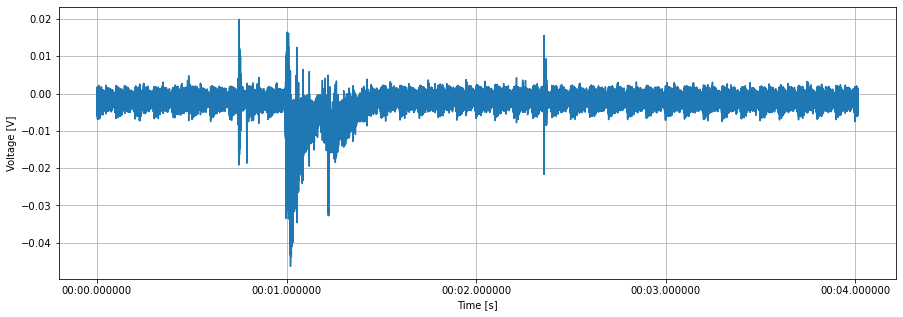

In [37]:
plt.figure(figsize=(15,5))
plt.plot(xx)

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

# .WFM parser

Populating the interactive namespace from numpy and matplotlib
/storage/experiments/2021/0822_bourka_sobeslav_auto1/slavia/1629713263.1639943.wfm
500000032 125000000
/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713263.1639943.mp4.csv


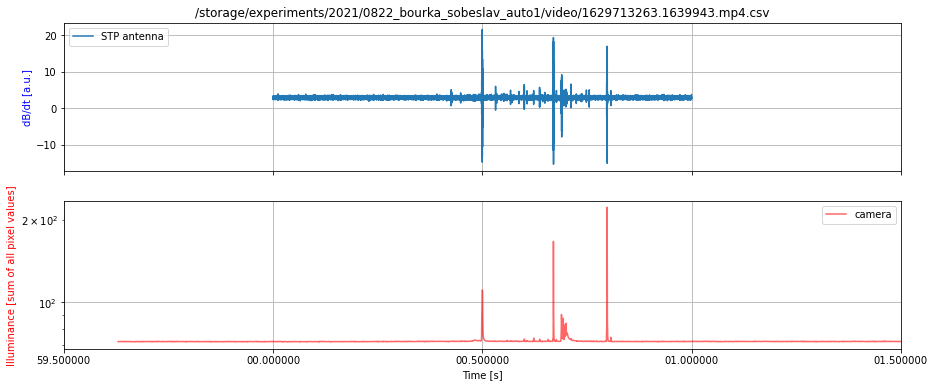

/storage/experiments/2021/0822_bourka_sobeslav_auto1/slavia/1629713811.182914.wfm
500000032 125000000
/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713811.182914.mp4.csv


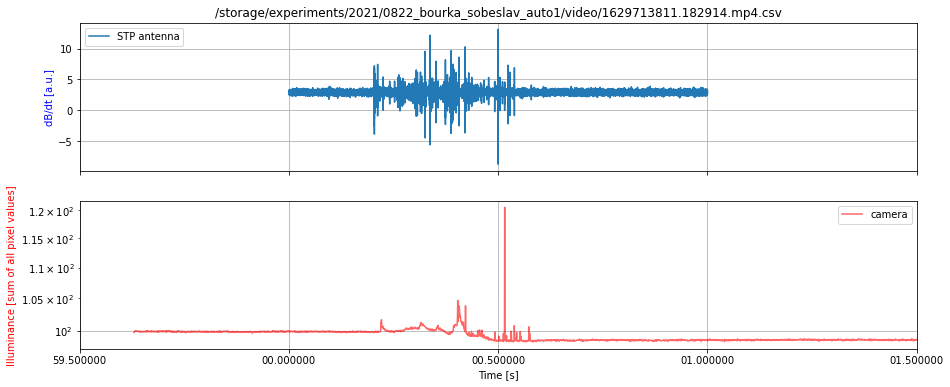

/storage/experiments/2021/0822_bourka_sobeslav_auto1/slavia/1629713139.3655908.wfm
500000032 125000000
/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713139.3655908.mp4.csv


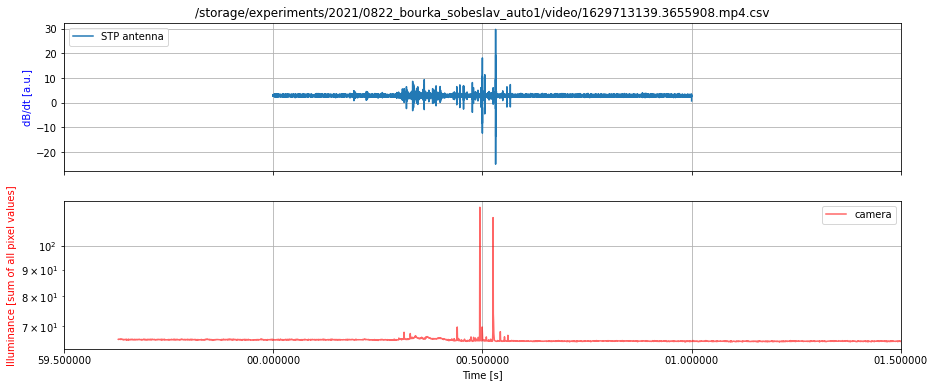

/storage/experiments/2021/0822_bourka_sobeslav_auto1/slavia/1629713039.542304.wfm
500000032 125000000
/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713039.542304.mp4.csv


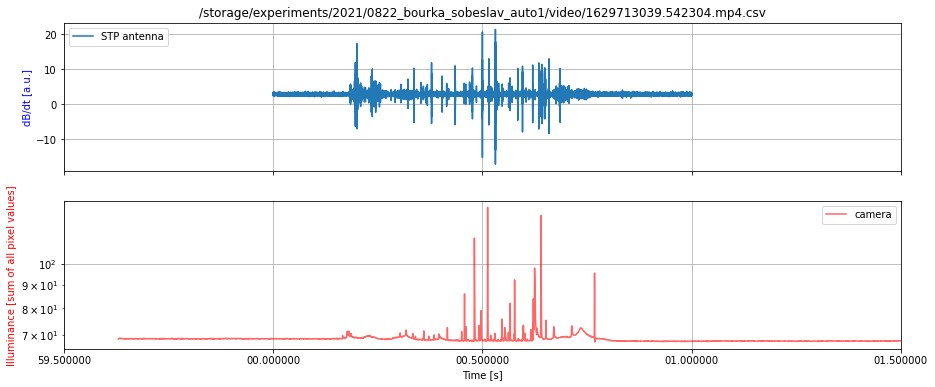

/storage/experiments/2021/0822_bourka_sobeslav_auto1/slavia/1629713408.9740598.wfm
500000032 125000000
/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713408.9740598.mp4.csv


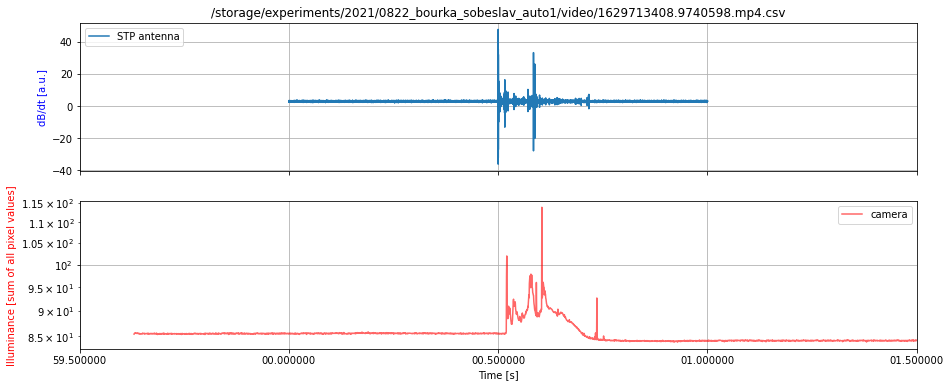

/storage/experiments/2021/0822_bourka_sobeslav_auto1/slavia/1629713599.020929.wfm
500000032 125000000
/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713599.020929.mp4.csv


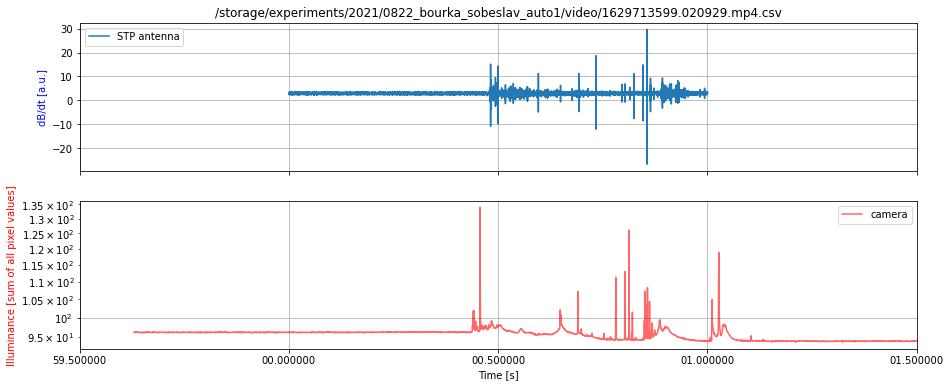

/storage/experiments/2021/0822_bourka_sobeslav_auto1/slavia/1629713496.3090317.wfm
500000032 125000000
/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713496.3090317.mp4.csv


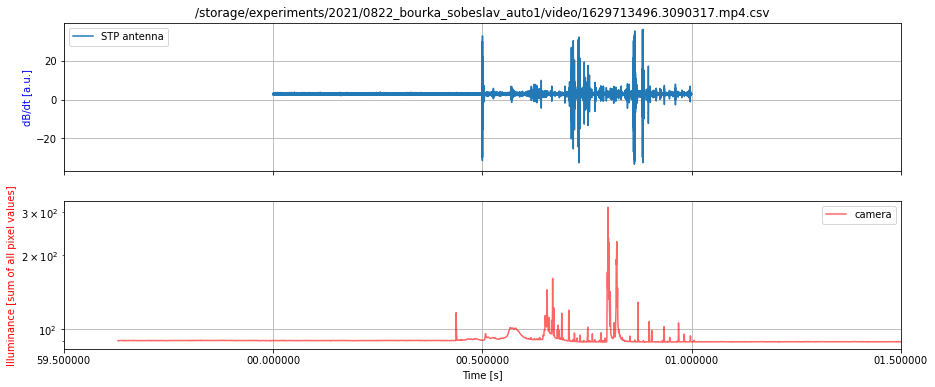

In [1]:
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
import matplotlib.dates as mdates
import datetime

%pylab inline --no-import-all

#directory = '/storage/experiments/2021/0726_bourka_zabori' 
#directory = '/storage/experiments/2021/0807_bourka_sobeslav' 
#directory = '/storage/experiments/2021/0725_bourka_ratmirov'
#directory = '/storage/experiments/2021/0803_bourka_votice'
#directory = '/storage/experiments/2021/0713_bourka_exit29_D8' # csv
#directory = '/storage/experiments/2021/0714_bourka_sobeslav' # jinak pojmenovane soubory
#directory = '/storage/experiments/2021/0815_bourka_veseli_auto1'
#directory = '/storage/experiments/2021/0816_bourka_sobeslav'
directory = '/storage/experiments/2021/0822_bourka_sobeslav_auto1'

for f in glob.iglob(directory + '/slavia/*.wfm'): # generator, search immediate subdirectories 
    wfm_file = f
    f = f.split('/')[-1:][0].split('.')
    video_file = directory + '/video/' + f[0] + '.' + f[1] + '.mp4.csv'
    try:
        dt = np.dtype([('a', 'u1')])
        bytes_read = np.fromfile(wfm_file, dtype=dt)
        print(wfm_file)
    except:
        continue
    
    offset = 0x10
    SetupSize = int.from_bytes(bytes_read[offset:offset+4], "big")
    offset = 0x14 + SetupSize + 0x1C
    LAdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
    offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x1c
    CHdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
    offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x30
    MemDepth = int.from_bytes(bytes_read[offset:offset+4], "big")
    print(CHdataSize, MemDepth)
    offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x39
    #ch1 = list(bytes_read[offset:offset+CHdataSize:2])
    #ch2 = bytes_read[offset+1:offset+CHdataSize:2]
    df = pd.DataFrame(bytes_read[offset+1:offset+CHdataSize:2])
    df['time']=pd.to_datetime(df.index*4e-9, unit='s', origin='unix') # fillin of correct sample time
    df.set_index('time', inplace=True)
    
    xx = df.resample('10us', closed='left').mean()
    
    try:
        y = pd.read_csv(video_file)
        print(video_file)
    except:
        continue
        
    y['time'] = (y.index)*(1/1610)

    fig, (ax1,  ax2) = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)

    ax1.plot(xx-128, label='STP antenna', alpha=0.99)
    #plt.xlabel('Time [s]')
    ax1.set_ylabel('dB/dt [a.u.]', c='b')
    ax1.grid()
    ax1.legend(loc = "upper left")
    ax1. set_title(video_file)

    #ax1.set_xlim(pd.to_datetime(0, unit='s'),pd.to_datetime(0.8, unit='s'))
    ax1.set_xlim(pd.to_datetime(-0.5, unit='s'),pd.to_datetime(1.5, unit='s'))

    #y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.670, unit='s') # trigger in center
    y['time'] = pd.to_datetime((y.index)*(1/1612.38)-0.370, unit='s') # trigger in 200 ms

    ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
    ax2.set_yscale('log')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Illuminance [sum of all pixel values]', c='r')
    ax2.grid()
    ax2.legend(loc = "upper right")
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%S.%f'))
    #plt.ylim(90,10e2) 
    plt.savefig(directory + '/video/x/' + f[0] + '.' + f[1] + '.png')
    plt.show()
    